In [1]:
import math
import jax
from jax import jit, vmap, value_and_grad,lax
import jax.numpy as jnp
import optax
import jaxley as jx
import jaxley.optimize.transforms as jt
import jax.scipy as jsp
import matplotlib.pyplot as plt
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

In [2]:
from functools import partial
import jax
import jax.numpy as jnp

def set_two_params(phys_base, keys, idxs, p_vec):
    """Return a params dict equal to phys_base except two scalars replaced by p_vec[0], p_vec[1]."""
    out = {k: v.copy() for k, v in phys_base.items()}
    out[keys[0]] = out[keys[0]].at[idxs[0]].set(p_vec[0])
    out[keys[1]] = out[keys[1]].at[idxs[1]].set(p_vec[1])
    return out

def one_hot(n, i):
    v = jnp.zeros((n,), jnp.float64)
    return v.at[i].set(1.0)


In [3]:
# A_t is the full simulator state the step needs (for HH it includes V and gates).
# If your model.step only needs V_t (and keeps gates internally), adapt the signature accordingly.
def step_fn(A_t, p_vec, I_t, phys_base, keys, idxs, model, dt):
    params = set_two_params(phys_base, keys, idxs, p_vec)
    return model.step(A_t, params, I_t, dt)     # -> A_{t+1}


In [4]:
def forward_factorization(A_seq, p_vec, I_seq, phys_base, keys, idxs, model, dt,
                          readout_c, dℓ_dv_seq):
    """
    Returns:
      grad_vec: (2,)
      S_read_seq: (T, 2)     readout sensitivities s_t = ∂v_t/∂p for both params
      S_full_seq: (T, D, 2)  full-state sensitivities S_t (optional to inspect)
    """
    T, D = I_seq.shape[0], A_seq.shape[1]
    step = partial(step_fn, phys_base=phys_base, keys=keys, idxs=idxs, model=model, dt=dt)

    # Jacobians of one step
    J_A  = jax.jacrev(lambda A, p, I: step(A, p, I), argnums=0)
    J_P2 = jax.jacrev(lambda A, p, I: step(A, p, I), argnums=1)  # wrt 2-vector p_vec

    S_t = jnp.zeros((D, 2), dtype=jnp.float64)
    S_read_list, S_full_list = [], []

    for t in range(T):
        A_t, I_t = A_seq[t], I_seq[t]
        FA = J_A(A_t, p_vec, I_t)     # (D, D)
        FP = J_P2(A_t, p_vec, I_t)    # (D, 2)
        S_t = FA @ S_t + FP           # (D, 2)
        S_full_list.append(S_t)
        # readout sensitivity s_t = ∂v_t/∂p = c^T S_t  → shape (2,)
        s_t = (readout_c @ S_t)       # (2,)
        S_read_list.append(s_t)

    S_read_seq = jnp.stack(S_read_list, axis=0)   # (T, 2)
    S_full_seq = jnp.stack(S_full_list, axis=0)   # (T, D, 2)

    # contract with error: ∑_t S_t^T e_t ; here e_t = epsilon_t * c
    # but since e_t = epsilon_t * c, S_t^T e_t = epsilon_t * (c^T S_t) = epsilon_t * s_t
    grad_vec = (dℓ_dv_seq[:, None] * S_read_seq).sum(axis=0)   # (2,)
    return grad_vec, S_read_seq, S_full_seq


In [5]:
SAFE_Z   = 1e-4
EXP_CLIP = 60.0

def safe_exp(x): return jnp.exp(jnp.clip(x, -EXP_CLIP, EXP_CLIP))

def vtrap(dx, k):
    z = dx / k
    taylor = 1.0 - z/2.0 + (z*z)/12.0 - (z**4)/720.0
    return jnp.where(jnp.abs(z) < SAFE_Z, k * taylor, dx / jnp.expm1(z))

def alpha_m(v): return 0.1  * vtrap(25.0 - v, 10.0)
def beta_m(v):  return 4.0  * safe_exp(-v / 18.0)
def alpha_h(v): return 0.07 * safe_exp(-v / 20.0)
def beta_h(v):  return 1.0  / (safe_exp((30.0 - v)/10.0) + 1.0)
def alpha_n(v): return 0.01 * vtrap(10.0 - v, 10.0)
def beta_n(v):  return 0.125 * safe_exp(-v / 80.0)

def x_inf(alpha_fn, beta_fn, v):
    a, b = alpha_fn(v), beta_fn(v)
    return a / (a + b + 1e-12)

def gate_update(x, a, b, dt):
    inv_tau = a + b
    tau     = 1.0 / jnp.maximum(inv_tau, 1e-12)
    x_inf   = a * tau
    return jnp.clip(x_inf - (x_inf - x) * jnp.exp(-dt / tau), 0.0, 1.0)

# Cable coupling (axial G matrix)
def build_tridiagonal_gax(n_comp, g_link):
    """Line cable; uniform axial conductance g_link (S/cm^2 equiv)."""
    G = jnp.zeros((n_comp, n_comp))
    idx = jnp.arange(n_comp - 1)
    G = G.at[idx, idx+1].set(-g_link)
    G = G.at[idx+1, idx].set(-g_link)
    G = G.at[jnp.arange(n_comp), jnp.arange(n_comp)].set(-jnp.sum(G, axis=1))
    return G  # symmetric PSD

# One cable step (implicit V, RL gates)
@jit
def hh_step_cable(state, I_inj_vec, params, dt, Gax):
    """
    state: (v, m, h, n), each (N,)
    I_inj_vec: (N,)
    params: dict with per-comp arrays (N,) or scalars broadcastable
    Gax: (N,N) axial conductance matrix
    """
    v, m, h, n = state

    # rates at V_t
    am, bm = alpha_m(v), beta_m(v)
    ah, bh = alpha_h(v), beta_h(v)
    an, bn = alpha_n(v), beta_n(v)

    # Rush–Larsen gates → t+1
    m_new = gate_update(m, am, bm, dt)
    h_new = gate_update(h, ah, bh, dt)
    n_new = gate_update(n, an, bn, dt)

    gNa, gK, gL = params["HH_gNa"], params["HH_gK"], params["HH_gL"]
    ENa, EK, EL = params["HH_ENa"], params["HH_EK"], params["HH_EL"]
    Cm          = params["C_m"]

    # ionic conductances at t+1 gates (canonical m^3 h)
    gNa_eff = gNa * (m_new**3) * h_new
    gK_eff  = gK  * (n_new**4)
    gion    = gNa_eff + gK_eff + gL            # (N,)
    Irev    = gNa_eff*ENa + gK_eff*EK + gL*EL  # (N,)

    # implicit Euler: (C/dt I + diag(gion) + Gax) v_{t+1} = (C/dt) v_t + Irev + I_inj
    A = jnp.diag(Cm / dt + gion) + Gax
    b = (Cm/dt) * v + Irev + I_inj_vec
    v_new = jsp.linalg.solve(A, b)


    return (v_new, m_new, h_new, n_new), v_new

def integrate_cable(state0, currents, params, dt, Gax):
    """currents: (T,N)"""
    def step(carry, I_t):
        return hh_step_cable(carry, I_t, params, dt, Gax)
    final_state, v_trace = lax.scan(step, state0, currents)
    return final_state, v_trace  # (T,N)

In [6]:
class MultiCompHH:
    def __init__(self, n_comp=5, default_params=None, g_link=0.2):
        self.n = n_comp
        base = {
            "HH_gNa": 120.0*jnp.ones(n_comp),
            "HH_gK":   36.0*jnp.ones(n_comp),
            "HH_gL":    0.3*jnp.ones(n_comp),
            "HH_ENa":  50.0*jnp.ones(n_comp),
            "HH_EK":  -77.0*jnp.ones(n_comp),
            "HH_EL":  -54.387*jnp.ones(n_comp),
            "C_m":      1.0*jnp.ones(n_comp),
        }
        if default_params is not None:
            base.update(default_params)
        self.params = base
        self.g_link = g_link
        self.Gax    = build_tridiagonal_gax(n_comp, g_link)

    def simulate(self, params_physical, currents, dt=0.025, t_equil_ms=25.0):
        """
        currents: (T,N), inject at soma via currents[:,0], others 0
        returns (T,N)
        """
        v0 = params_physical["HH_EL"]  # (N,)
        m0 = x_inf(alpha_m, beta_m, v0)
        h0 = x_inf(alpha_h, beta_h, v0)
        n0 = x_inf(alpha_n, beta_n, v0)
        state0 = (v0, m0, h0, n0)

        _, V = integrate_cable(state0, currents, params_physical, dt, self.Gax)
        return V


In [7]:
class IdentityTransform:
    def forward(self, x): return x
    def inverse(self, x): return x

def build_transform(n):
    return jx.ParamTransform({
        "HH_gNa": jt.SigmoidTransform(0.0, 400.0),     # (N,)
        "HH_gK":  jt.SigmoidTransform(0.0, 200.0),     # (N,)
        "HH_gL":  jt.SigmoidTransform(0.0,  10.0),     # (N,)
        "HH_ENa": jt.SigmoidTransform(-100.0, 100.0),  # (N,)
        "HH_EK":  jt.SigmoidTransform(-150.0,  50.0),
        "HH_EL":  jt.SigmoidTransform(-120.0,   0.0),
        "C_m":    IdentityTransform(),                
    })

In [8]:
def make_soma_step_batch(B, T, N, dt, delay=5.0, dur=20.0, amps=None, seed=0):
    t = jnp.arange(T) * dt
    mask = ((t >= delay) & (t < delay + dur)).astype(jnp.float32)  # (T,)
    if amps is None:
        rng = jax.random.PRNGKey(seed)
        amps = jax.random.normal(rng, (B,)) * 8.0  # (B,)
    I = jnp.zeros((B, T, N))
    I = I.at[:, :, 0].set(amps[:, None] * mask[None, :])  # soma-only
    return I, amps

def simulate_from_optparams(opt_params_pytree, batch_currents, model, dt=0.025):
    """
    batch_currents: (B,T,N)
    returns: (B,T,N)
    """
    params_physical = transform.forward(opt_params_pytree)  # dict of (N,)
    def one(bI):
        return model.simulate(params_physical, bI, dt=dt)
    return vmap(one)(batch_currents)

def loss_wave(opt_params_pytree, batch_currents, targets, model, dt):
    sim = simulate_from_optparams(opt_params_pytree, batch_currents, model, dt)
    return jnp.mean((sim - targets)**2)

def loss_mean(opt_params_pytree, batch_currents, targets, model, dt):
    sim = simulate_from_optparams(opt_params_pytree, batch_currents, model, dt)
    return jnp.mean((jnp.mean(sim, axis=(1,2)) - jnp.mean(targets, axis=(1,2)))**2)

# unified loss to avoid retraces when toggling
def unified_loss(opt_params_pytree, batch_currents, targets, model, dt, use_waveform: bool):
    def _wave(_):
        return loss_wave(opt_params_pytree, batch_currents, targets, model, dt)
    def _mean(_):
        return loss_mean(opt_params_pytree, batch_currents, targets, model, dt)
    return lax.cond(use_waveform, _wave, _mean, operand=None)

In [9]:
PARAM_KEYS_TO_TRACK = ["HH_gNa", "HH_gK", "HH_ENa", "HH_EK", "HH_EL"]

def tree_global_l2(tree):
    return optax.global_norm(tree)

def tree_param_l2s(grads, keys=PARAM_KEYS_TO_TRACK):
    out = {}
    for k in keys:
        if k in grads:
            out[k] = jnp.sqrt(jnp.sum(jnp.square(grads[k])))  # across compartments
    return out

def ema(xs, alpha=0.9):
    if not xs: return []
    sm = [xs[0]]
    for x in xs[1:]:
        sm.append(alpha*sm[-1] + (1-alpha)*x)
    return sm

In [10]:
N  = 5
dt = 0.025
t_max = 50.0
T = int(math.ceil(t_max / dt))
model = MultiCompHH(n_comp=N, g_link=0.2)

transform = build_transform(N)
params_phys0 = model.params
opt_params0  = transform.inverse(params_phys0)

# Batch currents
B = 32
batch_currents, amps = make_soma_step_batch(B, T, N, dt, delay=5.0, dur=20.0, seed=0)

# Teacher
teacher_opt = transform.inverse(transform.forward(opt_params0))  # identity, explicit
with jax.disable_jit():
    teacher_volts = simulate_from_optparams(teacher_opt, batch_currents, model, dt)  # (B,T,N)

USE_WAVEFORM = True
targets = teacher_volts

# Learner init (perturb a few params)
learner_phys = {k: v.copy() for k, v in params_phys0.items()}
learner_phys["HH_gNa"] = learner_phys["HH_gNa"] * 0.8
learner_phys["HH_gK"]  = learner_phys["HH_gK"]  * 1.1
learner_phys["HH_EL"]  = learner_phys["HH_EL"]  + 2.0
params = transform.inverse(learner_phys)

from jax import tree_util as tu

# Boolean mask (same pytree as params): True = train, False = freeze
mask = tu.tree_map(lambda x: jnp.ones_like(x, dtype=bool), params)

optimizer = optax.chain(
optax.clip_by_global_norm(1.0),
optax.adamw(1e-3),
)
opt_state = optimizer.init(params)

# JIT loss/grad
grad_fn = jit(value_and_grad(lambda p, I, Y: unified_loss(p, I, Y, model, dt, USE_WAVEFORM), argnums=0))

# Logs
loss_hist = []
grad_hist_global = []
grad_hist_perkey = {k: [] for k in PARAM_KEYS_TO_TRACK}

steps = 1000
for step in range(steps+1):
    loss_val, grads = grad_fn(params, batch_currents, targets)

    # record grads
    gnorm = float(tree_global_l2(grads))
    per   = tree_param_l2s(grads)
    loss_hist.append(float(loss_val))
    grad_hist_global.append(gnorm)
    for k in grad_hist_perkey:
        grad_hist_perkey[k].append(float(per.get(k, 0.0)))

    # update
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    if step % 50 == 0:
        print(f"step {step:4d}  loss={float(loss_val):.3e}  gnorm={gnorm:.3e}")


Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/n/home12/isanchez/.conda/envs/itzeljax/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/n/home12/isanchez/.conda/envs/itzeljax/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 85, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'


step    0  loss=3.999e+00  gnorm=5.279e+01
step   50  loss=2.683e-01  gnorm=1.354e+01
step  100  loss=3.291e-04  gnorm=4.679e-01
step  150  loss=3.301e-06  gnorm=3.568e-02
step  200  loss=7.254e-07  gnorm=1.869e-03
step  250  loss=5.499e-07  gnorm=9.513e-05
step  300  loss=4.275e-07  gnorm=1.502e-05
step  350  loss=3.291e-07  gnorm=1.082e-05
step  400  loss=2.493e-07  gnorm=9.768e-06
step  450  loss=1.859e-07  gnorm=8.988e-06
step  500  loss=1.364e-07  gnorm=8.334e-06
step  550  loss=9.855e-08  gnorm=7.798e-06
step  600  loss=7.014e-08  gnorm=7.357e-06
step  650  loss=4.917e-08  gnorm=6.993e-06
step  700  loss=3.397e-08  gnorm=6.688e-06
step  750  loss=2.313e-08  gnorm=6.426e-06
step  800  loss=1.553e-08  gnorm=6.197e-06
step  850  loss=1.030e-08  gnorm=5.992e-06
step  900  loss=6.756e-09  gnorm=5.803e-06
step  950  loss=4.402e-09  gnorm=5.625e-06
step 1000  loss=2.865e-09  gnorm=5.457e-06


Final RMSE (waveform): 5.3296962578901616e-05
HH_gNa  Max Abs Deviation = 24.023124
HH_gK   Max Abs Deviation = 5.063945
HH_gL   Max Abs Deviation = 0.000002
HH_ENa  Max Abs Deviation = 0.804859
HH_EK   Max Abs Deviation = 2.446682
HH_EL   Max Abs Deviation = 0.000020
C_m     Max Abs Deviation = 0.000007


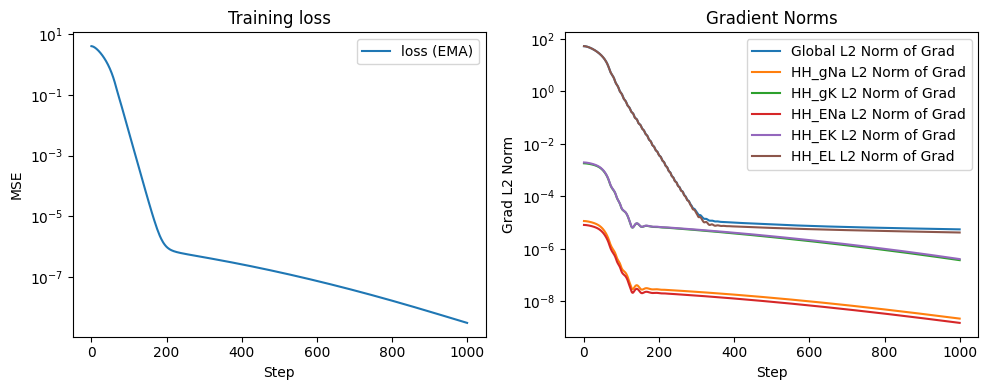

In [11]:
# Final waveform RMSE on training batch
sim_final = simulate_from_optparams(params, batch_currents, model, dt)
rmse = float(jnp.sqrt(jnp.mean((sim_final - targets)**2)))
print("Final RMSE (waveform):", rmse)

# Parameter diffs 
phys_est  = transform.forward(params)
phys_true = transform.forward(teacher_opt)
for k in ["HH_gNa","HH_gK","HH_gL","HH_ENa","HH_EK","HH_EL","C_m"]:
    if k in phys_est:
        delta = float(jnp.max(jnp.abs(phys_est[k] - phys_true[k])))
        print(f"{k:7s} Max Abs Deviation = {delta:.6f}")

steps_ax = range(len(loss_hist))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(steps_ax, ema(loss_hist, 0.9), label="loss (EMA)")
plt.yscale("log"); plt.xlabel("Step"); plt.ylabel("MSE"); plt.title("Training loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(steps_ax, ema(grad_hist_global, 0.9), label="Global L2 Norm of Grad")
for k, series in grad_hist_perkey.items():
    if any(s > 0 for s in series):
        plt.plot(steps_ax, ema(series, 0.9), label=f"{k} L2 Norm of Grad")
plt.yscale("log"); plt.xlabel("Step"); plt.ylabel("Grad L2 Norm"); plt.title("Gradient Norms")
plt.legend()
plt.tight_layout()
plt.show()

Experiment 1


In [12]:
def make_step_injection(T, N, dt, inj_idx, delay=5.0, dur=20.0, amp=8.0):
    t = jnp.arange(T) * dt
    mask = ((t >= delay) & (t < delay + dur)).astype(jnp.float64)  # T,
    I = jnp.zeros((T, N), dtype=jnp.float64)
    I = I.at[:, inj_idx].set(amp * mask)
    return I  # (T, N)

In [13]:
def loss_soma_mse(phys_params, currents, target_soma, model, dt):
    V = model.simulate(phys_params, currents, dt=dt)   # (T, N)
    pred_soma = V[:, 0]
    return jnp.mean((pred_soma - target_soma)**2), pred_soma  # return pred for factorization

In [14]:
def replace_scalar(tree, key, idx, new_val):
    return { **tree, key: tree[key].at[idx].set(new_val) }

def vsoma_from_scalar_param(p_scalar, phys_params, key, idx, currents, model, dt):
    new_params = replace_scalar(phys_params, key, idx, p_scalar)
    V = model.simulate(new_params, currents, dt=dt)
    return V[:, 0]  # (T,)

def dVsoma_dp(phys_params, key, idx, currents, model, dt):
    p0 = phys_params[key][idx]
    f  = lambda p_scalar: vsoma_from_scalar_param(p_scalar, phys_params, key, idx, currents, model, dt)
    # jacobian fwd over a scalar -> returns a (T,) sensitivity
    return jax.jacfwd(f)(p0)  # (T,)

In [15]:
def dL_dVsoma(pred_soma, target_soma):
    T = pred_soma.shape[0]
    return (2.0 / T) * (pred_soma - target_soma)  # (T,)

In [16]:
def chain_check(dL_dV, dV_dp, grad_p):
    return float(jnp.vdot(dL_dV, dV_dp)), float(grad_p)

In [17]:
# --------- helpers for shapes and windows ----------
def one_hot(n, idx):
    v = jnp.zeros((n,), dtype=jnp.float64)
    return v.at[idx].set(1.0)

def window_slicer(delay, dur, dt):
    t0 = int(jnp.floor(delay / dt))
    n  = int(jnp.floor(dur   / dt))
    return slice(t0, t0+n), t0, n

def print_shapes(tag, **tensors):
    print(f"\n[{tag}] shapes:")
    for k, v in tensors.items():
        if v is None: 
            print(f"  {k}: None")
        else:
            print(f"  {k}: {tuple(v.shape)}")

# --------- full-state sensitivities 
def V_full_from_scalar_param(p_scalar, phys_params, key, idx, currents, model, dt):
    new_params = replace_scalar(phys_params, key, idx, p_scalar)
    # Full state voltage traces (T, N)
    return model.simulate(new_params, currents, dt=dt)

def full_state_sensitivity(phys_params, key, idx, currents, model, dt):
    """Returns dA(t)/dp as an array of shape (T, N) for a single scalar param p=key[idx]."""
    p0 = phys_params[key][idx]
    f  = lambda p_scalar: V_full_from_scalar_param(p_scalar, phys_params, key, idx, currents, model, dt)
    return jax.jacfwd(f)(p0)  # (T, N)


def plot_readout_inner_product(time, dL_dV, sens, contrib, title):
    fig = plt.figure(figsize=(10, 6))
    ax1 = plt.subplot(3,1,1)
    ax1.plot(time, dL_dV)
    ax1.set_title(f"{title} – error at soma, x_t = dL/dV")
    ax1.set_xlabel("time"); ax1.set_ylabel("x_t")

    ax2 = plt.subplot(3,1,2)
    ax2.plot(time, sens)
    ax2.set_title(f"{title} – readout sensitivity, y_t = dv/dp")
    ax2.set_xlabel("time"); ax2.set_ylabel("y_t")

    ax3 = plt.subplot(3,1,3)
    ax3.plot(time, contrib, label="z_t = x_t·y_t")
    ax3.plot(time, jnp.cumsum(contrib), label="cumulative sum")
    ax3.set_title(f"{title} – per-time contribution and cumulative sum")
    ax3.set_xlabel("time"); ax3.set_ylabel("z_t / cum(z)")
    ax3.legend()
    plt.tight_layout()
    plt.show()

def plot_fullstate_heatmap(time, per_dim_contrib, comp_labels=None, title="Per-dim contributions xy"):
    # per_dim_contrib: (T, N) with entries e_t[d]*S_t[d]
    fig = plt.figure(figsize=(10, 4))
    plt.imshow(per_dim_contrib.T, aspect='auto', origin='lower',
               extent=(time[0], time[-1], 0, per_dim_contrib.shape[1]))
    plt.colorbar(label="z_t^(d) = x_t^(d)·y_t^(d)")
    plt.title(title)
    plt.xlabel("time")
    plt.ylabel("state dim (compartment)")
    if comp_labels is not None:
        plt.yticks(range(len(comp_labels)), comp_labels)
    plt.tight_layout()
    plt.show()



[inj 0] shapes:
  V: (2000, 5)
  pred_soma: (2000,)
  dL_dV: (2000,)
  sens_K: (2000,)
  sens_Na: (2000,)
  zfull_K: (2000, 5)
  zfull_Na: (2000, 5)


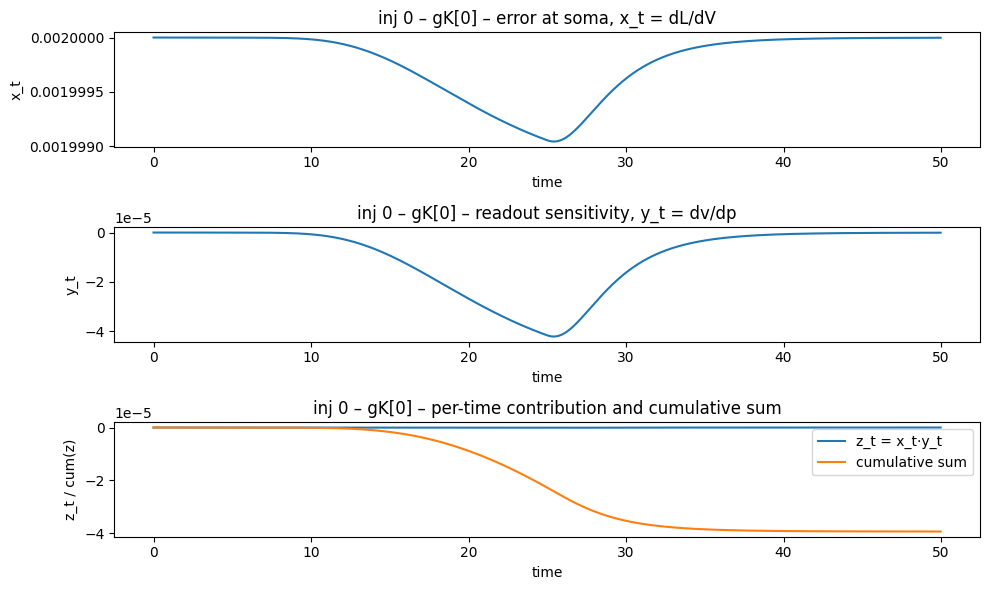

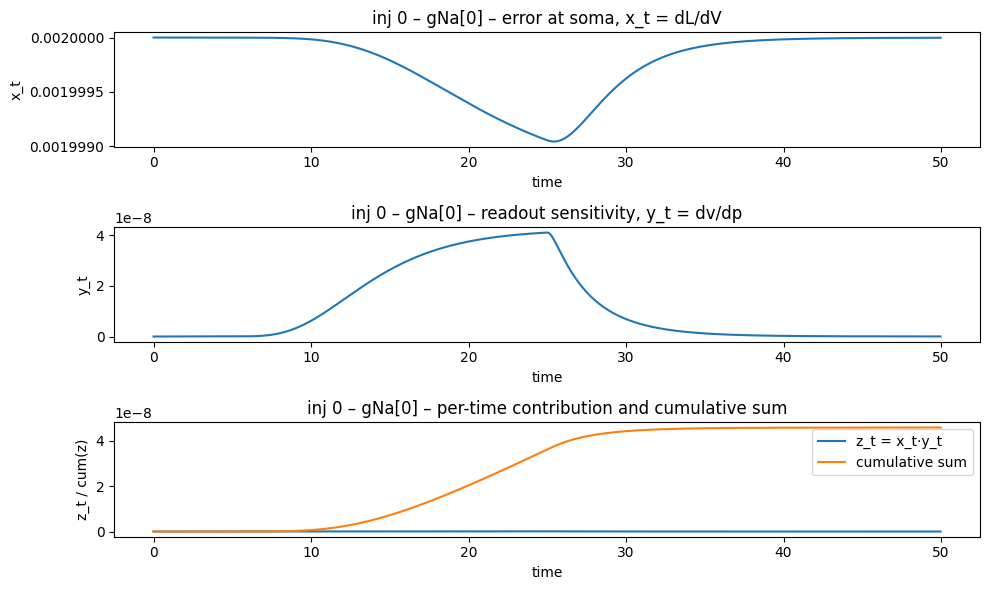

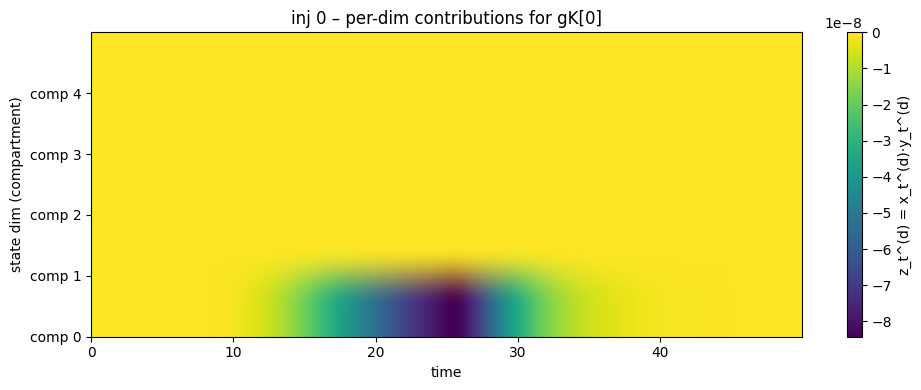

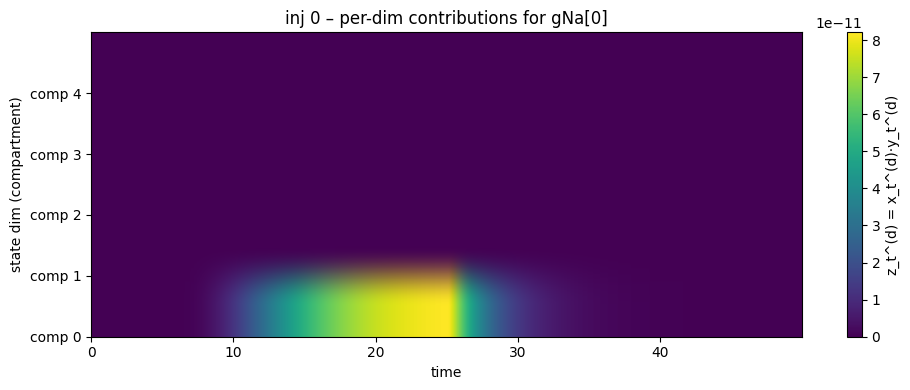

Gradient matrix G [inj_idx x {gK, gNa}]:
 [[-3.93363527e-05  4.58515013e-08]
 [-3.19931907e-06  3.14581671e-09]
 [-9.03549304e-07  8.78537889e-10]
 [-3.23494034e-07  3.18833679e-10]
 [-4.97822171e-07  5.82891948e-10]]
Factorized dot(dL/dV_soma, dV_soma/dp):
 [[-3.93363527e-05  4.58515013e-08]
 [-3.19931907e-06  3.14581671e-09]
 [-9.03549304e-07  8.78537889e-10]
 [-3.23494034e-07  3.18833679e-10]
 [-4.97822171e-07  5.82891948e-10]]
Max |difference| between full grad and factorized dot: 4.0657581468206416e-20


In [19]:
N  = 5
dt = 0.025
t_max = 50.0
T = int(math.ceil(t_max / dt))
model = MultiCompHH(n_comp=N, g_link=0.2)

# true teach physical params
phys_true = model.params

# Build per-injection targets
delay, dur, amp = 5.0, 20.0, 8.0
inj_currents = [make_step_injection(T, N, dt, i, delay, dur, amp) for i in range(N)]
targets_soma = []
with jax.disable_jit():
    for I_i in inj_currents:
        Vt = model.simulate(phys_true, I_i, dt=dt)
        targets_soma.append(Vt[:, 0])
targets_soma = [jnp.asarray(ts) for ts in targets_soma]

# perturbed physical params for learner
phys_learner = {k: v.copy() for k, v in phys_true.items()}
phys_learner["HH_gNa"] = phys_learner["HH_gNa"] * 0.8
phys_learner["HH_gK"]  = phys_learner["HH_gK"]  * 1.1
phys_learner["HH_EL"]  = phys_learner["HH_EL"]  + 2.0

# value_and_grad of the soma loss wrt physical params
loss_and_grad_phys = jax.value_and_grad(
    lambda p, I, y: loss_soma_mse(p, I, y, model, dt)[0],
    argnums=0
)

# 5x2 matrix of grads and the factorization check
G = jnp.zeros((N, 2), dtype=jnp.float64)        # [i, 0]=dL/dgK[i], [i,1]=dL/dgNa[i]
factor_dot = jnp.zeros_like(G)                  # same shape: dot(dL/dV, dV/dp)

# track per-injection time-series 
dLdV_all      = jnp.zeros((N, T), dtype=jnp.float64)  # dL/dV_soma(t) per injection
sensK_all     = jnp.zeros((N, T), dtype=jnp.float64)  # dV_soma/dgK[i] (t)
sensNa_all    = jnp.zeros((N, T), dtype=jnp.float64)  # dV_soma/dgNa[i] (t)
contribK_all  = jnp.zeros((N, T), dtype=jnp.float64)  # (dL/dV) * (dV/dgK[i])
contribNa_all = jnp.zeros((N, T), dtype=jnp.float64)  # (dL/dV) * (dV/dgNa[i])
losses        = jnp.zeros((N,),   dtype=jnp.float64)


# for i in range(N):
#     I_i, y_i = inj_currents[i], targets_soma[i]

#     # full gradient
#     (loss_i), grads_phys = loss_and_grad_phys(phys_learner, I_i, y_i)
#     gK_i  = grads_phys["HH_gK"][i]
#     gNa_i = grads_phys["HH_gNa"][i]
#     G = G.at[i, 0].set(gK_i)
#     G = G.at[i, 1].set(gNa_i)

#     # factorization pieces
#     loss_i_val, pred_soma_i = loss_soma_mse(phys_learner, I_i, y_i, model, dt)
#     dL_dV = dL_dVsoma(pred_soma_i, y_i)               # (T,)
#     sens_K  = dVsoma_dp(phys_learner, "HH_gK",  i, I_i, model, dt)   # (T,)
#     sens_Na = dVsoma_dp(phys_learner, "HH_gNa", i, I_i, model, dt)   # (T,)

#     # dot products (chain rule)
#     factor_dot = factor_dot.at[i, 0].set(jnp.vdot(dL_dV, sens_K))
#     factor_dot = factor_dot.at[i, 1].set(jnp.vdot(dL_dV, sens_Na))

#     dLdV_all      = dLdV_all.at[i].set(dL_dV)
#     sensK_all     = sensK_all.at[i].set(sens_K)
#     sensNa_all    = sensNa_all.at[i].set(sens_Na)
#     contribK_all  = contribK_all.at[i].set(dL_dV * sens_K)
#     contribNa_all = contribNa_all.at[i].set(dL_dV * sens_Na)
#     losses        = losses.at[i].set(loss_i_val)
time = jnp.arange(T) * dt
sl_win, t0, nwin = window_slicer(delay, dur, dt)
i_plot = 0  # choose which injection to visualize

for i in range(N):
    I_i, y_i = inj_currents[i], targets_soma[i]

    # full gradient via reverse-mode
    (loss_i), grads_phys = loss_and_grad_phys(phys_learner, I_i, y_i)
    gK_i  = grads_phys["HH_gK"][i]
    gNa_i = grads_phys["HH_gNa"][i]
    G = G.at[i, 0].set(gK_i)
    G = G.at[i, 1].set(gNa_i)

    # forward pieces (readout)
    loss_i_val, pred_soma_i = loss_soma_mse(phys_learner, I_i, y_i, model, dt)
    dL_dV = dL_dVsoma(pred_soma_i, y_i)                 # x_t (T,)
    sens_K  = dVsoma_dp(phys_learner, "HH_gK",  i, I_i, model, dt)   # y_t for gK[i]  (T,)
    sens_Na = dVsoma_dp(phys_learner, "HH_gNa", i, I_i, model, dt)   # y_t for gNa[i] (T,)

    # dot products (inner-product decomposition)
    factor_dot = factor_dot.at[i, 0].set(jnp.vdot(dL_dV, sens_K))
    factor_dot = factor_dot.at[i, 1].set(jnp.vdot(dL_dV, sens_Na))

    # store time series
    dLdV_all      = dLdV_all.at[i].set(dL_dV)
    sensK_all     = sensK_all.at[i].set(sens_K)
    sensNa_all    = sensNa_all.at[i].set(sens_Na)
    contribK_all  = contribK_all.at[i].set(dL_dV * sens_K)
    contribNa_all = contribNa_all.at[i].set(dL_dV * sens_Na)
    losses        = losses.at[i].set(loss_i_val)


    # turn the scalar x_t at soma into a full-state error vector x_t = x_t * c
    c = one_hot(N, 0)                    # pick soma (compartment 0)
    x_full = dL_dV[:, None] * c[None,:]  # (T,1) * (1,N) -> (T,N), only soma row nonzero

    yfull_K  = full_state_sensitivity(phys_learner, "HH_gK",  i, I_i, model, dt)   # (T,N)
    yfull_Na = full_state_sensitivity(phys_learner, "HH_gNa", i, I_i, model, dt)   # (T,N)

    # per-time per-dim contributions y_t^(d) = x_t^(d) * y_t^(d)
    zfull_K  = x_full * yfull_K
    zfull_Na = x_full * yfull_Na

    if i == i_plot:
        print_shapes(f"inj {i}",
                     V=model.simulate(phys_learner, I_i, dt=dt),
                     pred_soma=pred_soma_i,
                     dL_dV=dL_dV,
                     sens_K=sens_K, sens_Na=sens_Na,
                     zfull_K=zfull_K, zfull_Na=zfull_Na)

        # readout plots 
        plot_readout_inner_product(time, dL_dV, sens_K,  dL_dV * sens_K,  f"inj {i} – gK[{i}]")
        plot_readout_inner_product(time, dL_dV, sens_Na, dL_dV * sens_Na, f"inj {i} – gNa[{i}]")

        # --- full-state heatmap (shows xy across state-dims; here only soma row should be nonzero) ---
        comp_labels = [f"comp {k}" for k in range(N)]
        plot_fullstate_heatmap(time, zfull_K,  comp_labels, title=f"inj {i} – per-dim contributions for gK[{i}]")
        plot_fullstate_heatmap(time, zfull_Na, comp_labels, title=f"inj {i} – per-dim contributions for gNa[{i}]")

print("Gradient matrix G [inj_idx x {gK, gNa}]:\n", G)
print("Factorized dot(dL/dV_soma, dV_soma/dp):\n", factor_dot)
print("Max |difference| between full grad and factorized dot:",
      float(jnp.max(jnp.abs(G - factor_dot))))




In [22]:
import numpy as np

def plot_voltage_profiles_across_time(V_i, times, dt, title="", comp_labels=None, ylim=None):
    """
    V_i: array (T, C) voltage for a single injection site
    times: list of times (in ms) to snapshot, e.g., [0, 1, 2, 5, 10, 20]
    dt: simulation timestep (ms)
    comp_labels: optional list of length C, e.g., ["soma","1","2","3","4"]
    """
    T, C = V_i.shape
    if comp_labels is None:
        comp_labels = [f"{c}" for c in range(C)]
    xs = np.arange(C)

    # map times -> indices safely
    idxs = [min(int(round(t/dt)), T-1) for t in times]

    ncols = len(times)
    fig, axes = plt.subplots(1, ncols, figsize=(2.8*ncols, 3.0), sharey=True)
    if ncols == 1:
        axes = [axes]

    for ax, t_ms, ti in zip(axes, times, idxs):
        ax.plot(xs, np.asarray(V_i[ti, :]), marker="o", linewidth=1.5)
        ax.set_xticks(xs)
        ax.set_xticklabels(comp_labels, rotation=0)
        ax.set_title(f"t = {t_ms:.1f} ms")
        ax.grid(True, alpha=0.3)
        if ylim is not None:
            ax.set_ylim(*ylim)

    axes[0].set_ylabel("Voltage (mV)")
    fig.suptitle(title, y=1.05, fontsize=12)
    fig.tight_layout()
    plt.show()


In [23]:
def plot_all_injections(volts_by_inj, times, dt, comp_labels=None, ylim=None):
    """
    volts_by_inj: list of length 5; each element V_i has shape (T, C)
    times: list of snapshot times (ms)
    """
    for i, V_i in enumerate(volts_by_inj):
        plot_voltage_profiles_across_time(
            V_i, times, dt,
            title=f"Injection @ compartment {i}",
            comp_labels=comp_labels, ylim=ylim
        )


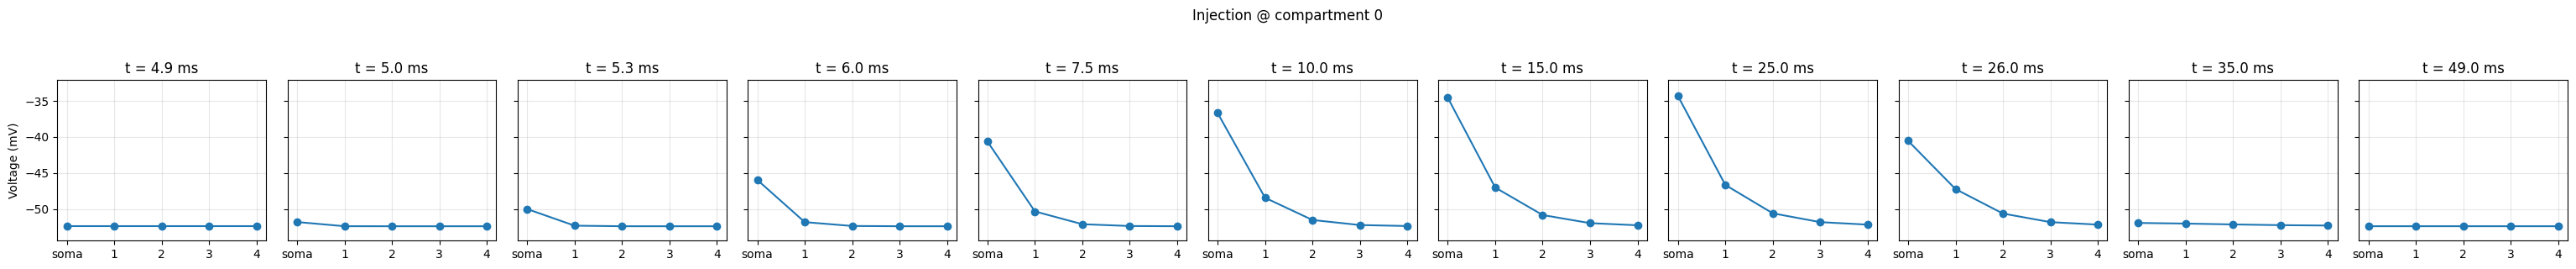

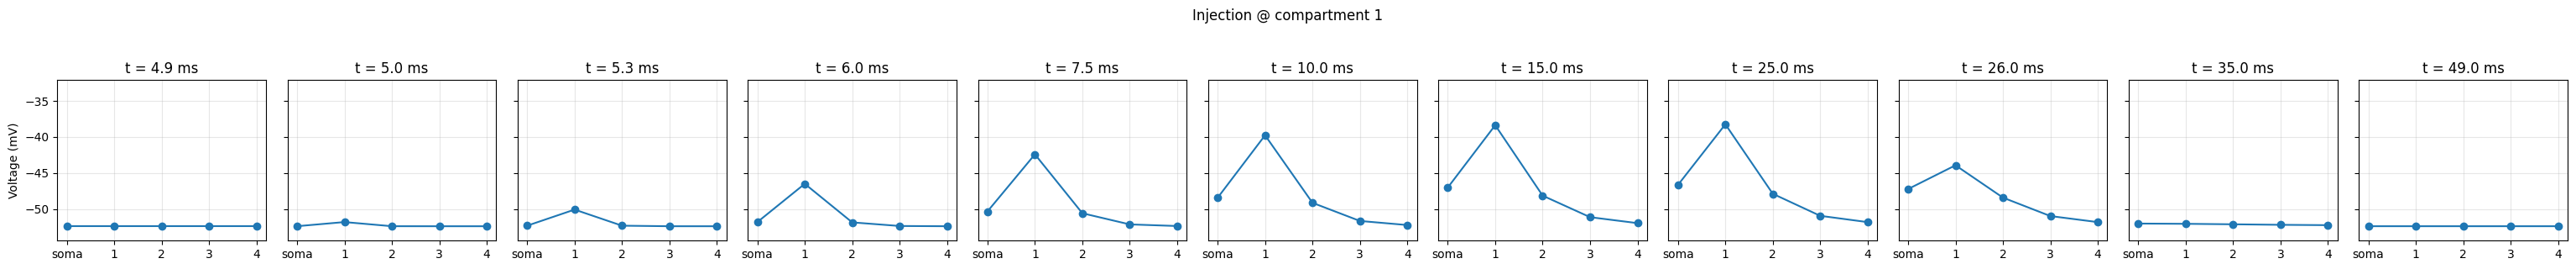

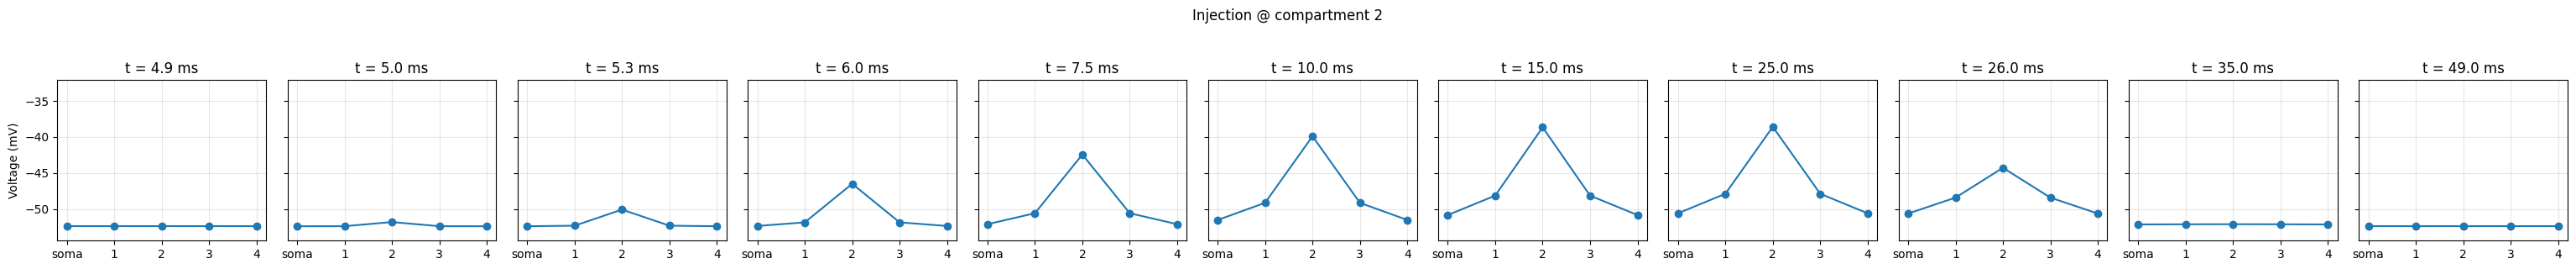

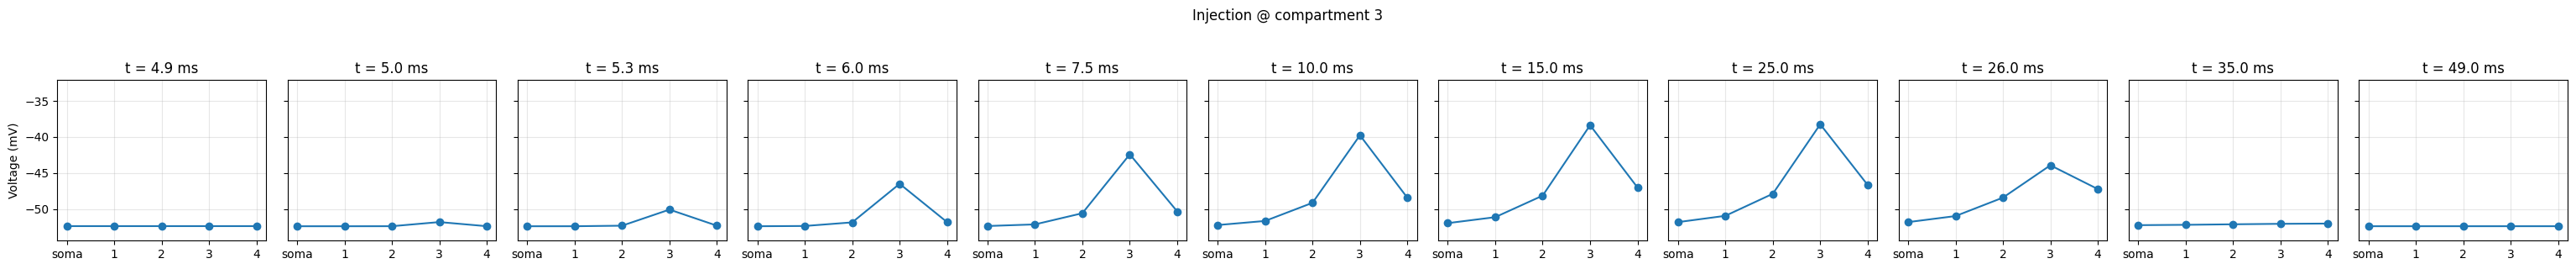

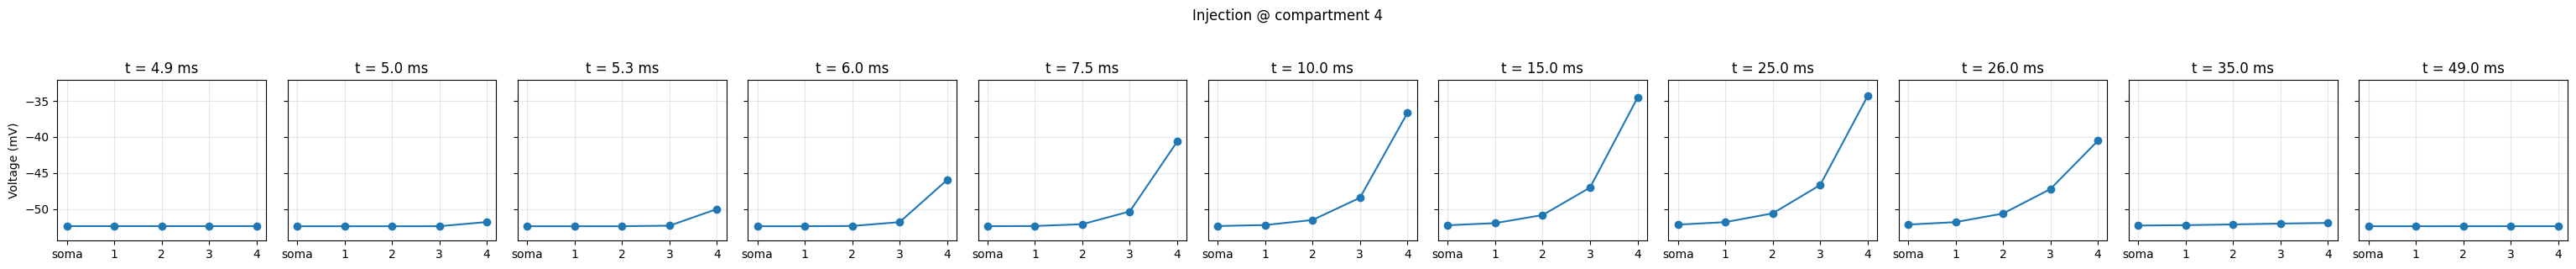

In [24]:
# 1) Build the per-injection voltage arrays (T, 5)
import numpy as np

with jax.disable_jit():  # plotting wants concrete arrays; optional but handy
    volts_by_inj = [np.asarray(model.simulate(phys_learner, I_i, dt=dt))
                    for I_i in inj_currents]
    # if you prefer the “true” params, swap phys_learner -> phys_true

# 2) Choose snapshot times (same units as your dt, i.e., ms here)
times = [4.9, 5.05, 5.30, 6.0, 7.5, 10.0, 15.0, 25.0, 26.0, 35.0, 49.0]

# 3) Labels and a shared y-axis range (optional but nice for comparisons)
comp_labels = ["soma", "1", "2", "3", "4"]
vmin = min(float(np.min(V)) for V in volts_by_inj)
vmax = max(float(np.max(V)) for V in volts_by_inj)
ylim = (vmin - 2.0, vmax + 2.0)

# 4) Call the helper to draw a row of panels per injection site
plot_all_injections(
    volts_by_inj,
    times,
    dt,
    comp_labels=comp_labels,
    ylim=ylim
)


In [25]:


def plot_spacetime_heatmap(V_i, dt, delay, title="", comp_labels=None, normalize=False):
    T, C = V_i.shape
    t = np.arange(T) * dt
    # baseline = mean pre-onset voltage per compartment
    b = V_i[:max(1, int(np.floor(delay/dt))), :].mean(axis=0, keepdims=True)
    dV = V_i - b
    if normalize:
        s = np.max(np.abs(dV), axis=0, keepdims=True) + 1e-9
        dV = dV / s  # unit scale per column

    plt.figure(figsize=(9, 3))
    plt.imshow(dV.T, aspect='auto', origin='lower',
               extent=(t[0], t[-1], 0, C))
    plt.colorbar(label="ΔV (mV)")
    plt.yticks(range(C), comp_labels or [f"{k}" for k in range(C)])
    plt.xlabel("time (ms)"); plt.ylabel("compartment")
    plt.title(title); plt.tight_layout(); plt.show()


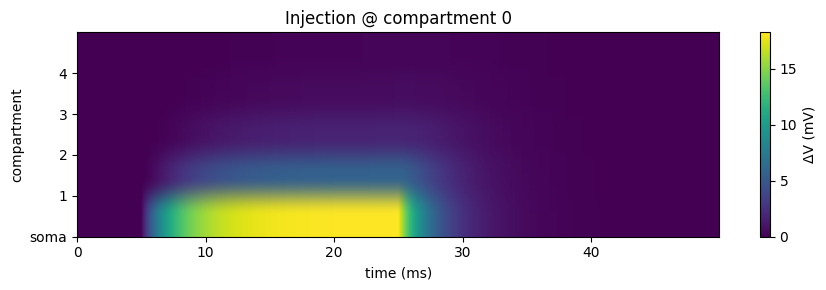

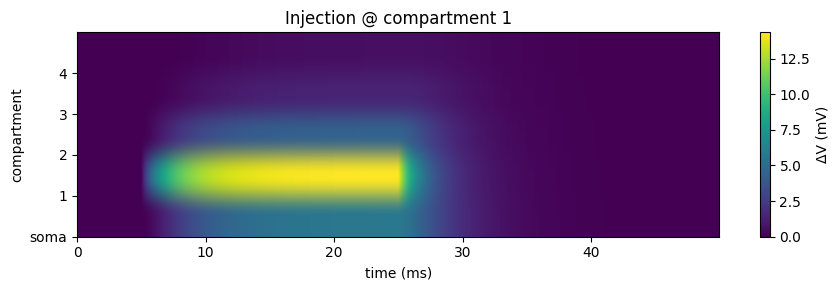

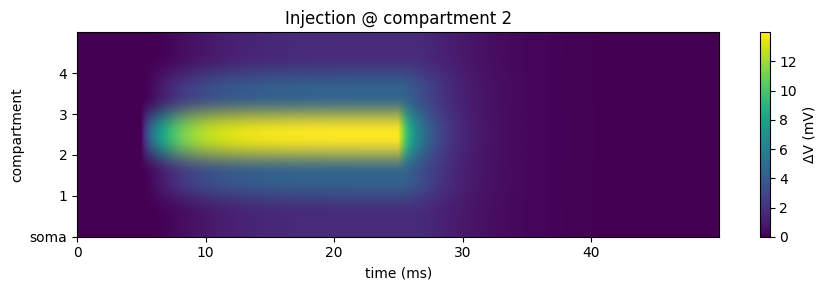

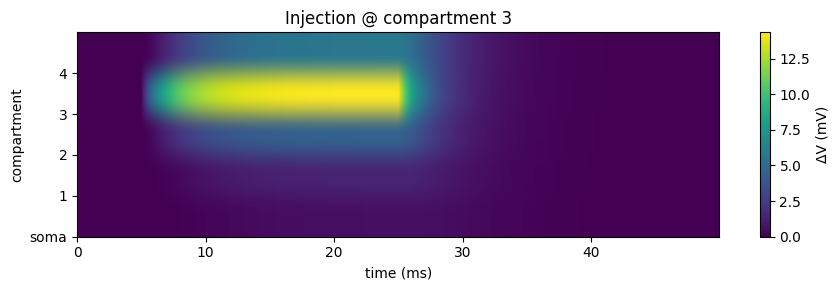

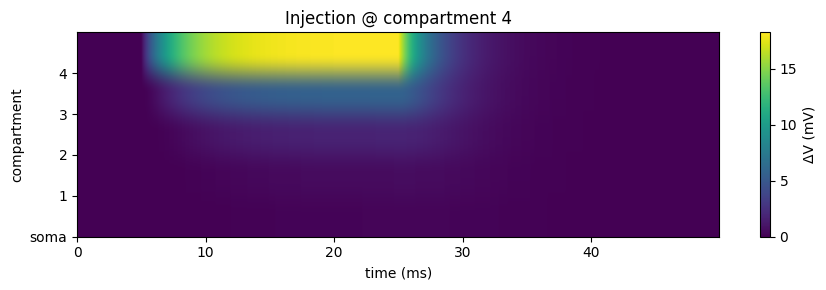

In [26]:
for i, V_i in enumerate(volts_by_inj):
    plot_spacetime_heatmap(V_i, dt, delay,
        title=f"Injection @ compartment {i}", comp_labels=["soma","1","2","3","4"])


In [27]:
# === 1) Run all five single-site injections and collect V(t,c) ===
import numpy as np
import jax

def simulate_all_injections(model, phys_params, inj_currents, dt):
    """Returns volts_by_inj: list of 5 arrays, each (T, C)"""
    volts_by_inj = []
    with jax.disable_jit():  # concrete arrays for plotting/saving
        for I_i in inj_currents:
            V = model.simulate(phys_params, I_i, dt=dt)  # (T, C) JAX array
            volts_by_inj.append(np.asarray(V))
    return volts_by_inj

# choose which parameter set to visualize
phys_params_for_viz = phys_learner  # or phys_true
volts_by_inj = simulate_all_injections(model, phys_params_for_viz, inj_currents, dt)

# quick sanity
T_check, C_check = volts_by_inj[0].shape
print(f"[info] collected V: {len(volts_by_inj)} injections, each shape = ({T_check}, {C_check})")


[info] collected V: 5 injections, each shape = (2000, 5)


In [28]:
# === 3) Plotting helpers (time traces, snapshots, and heatmaps) ===
import matplotlib.pyplot as plt

def plot_traces_for_injection(V_i, dt, delay=None, dur=None, title="", comp_labels=None, ylim=None):
    """
    V_i: (T, C) for one injection site.
    Plots V(t) for all compartments on one figure.
    """
    T, C = V_i.shape
    t = np.arange(T) * dt
    if comp_labels is None:
        comp_labels = [f"{k}" for k in range(C)]

    plt.figure(figsize=(8, 3.5))
    for c in range(C):
        plt.plot(t, V_i[:, c], label=comp_labels[c], linewidth=1.0)
    if delay is not None:
        plt.axvline(delay, color="k", alpha=0.3, linestyle="--", linewidth=1)
    if dur is not None and delay is not None:
        plt.axvline(delay + dur, color="k", alpha=0.3, linestyle="--", linewidth=1)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("time (ms)"); plt.ylabel("Voltage (mV)")
    plt.title(title); plt.legend(ncol=5, fontsize=8, frameon=False)
    plt.tight_layout(); plt.show()

def plot_spacetime_heatmap(V_i, dt, delay=None, title="", comp_labels=None, baseline_subtract=True):
    """
    Heatmap of V over time (x) and compartment (y).
    If baseline_subtract=True, subtract mean pre-onset per compartment for contrast.
    """
    T, C = V_i.shape
    t = np.arange(T) * dt
    M = V_i.copy()
    if baseline_subtract and delay is not None:
        t0 = max(1, int(np.floor(delay/dt)))
        b = M[:t0, :].mean(axis=0, keepdims=True)
        M = M - b

    plt.figure(figsize=(9, 3))
    plt.imshow(M.T, aspect='auto', origin='lower',
               extent=(t[0], t[-1], 0, C))
    plt.colorbar(label="V (mV)" if not baseline_subtract else "ΔV (mV)")
    plt.yticks(range(C), comp_labels or [f"{k}" for k in range(C)])
    plt.xlabel("time (ms)"); plt.ylabel("compartment")
    plt.title(title)
    plt.tight_layout(); plt.show()

# (you already have "plot_voltage_profiles_across_time" and "plot_all_injections";
# keep using those if you like the snapshot panels)


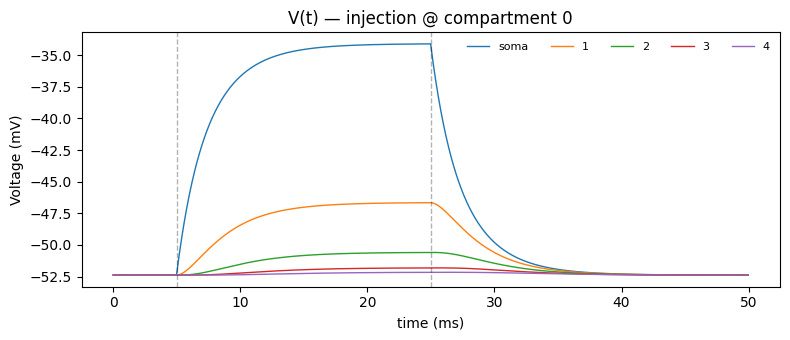

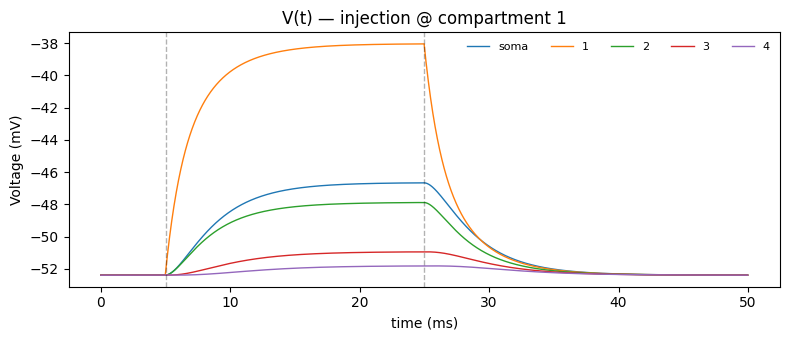

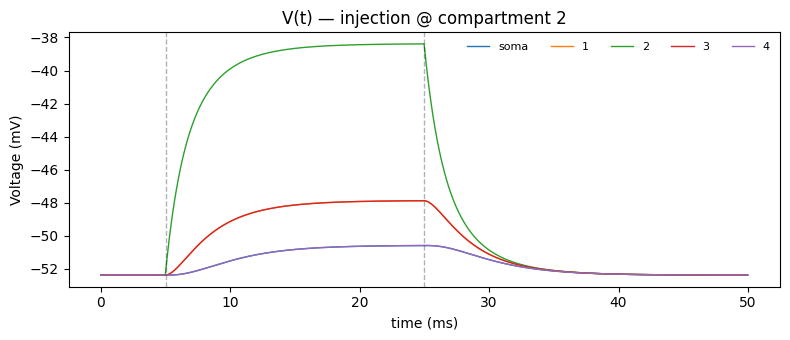

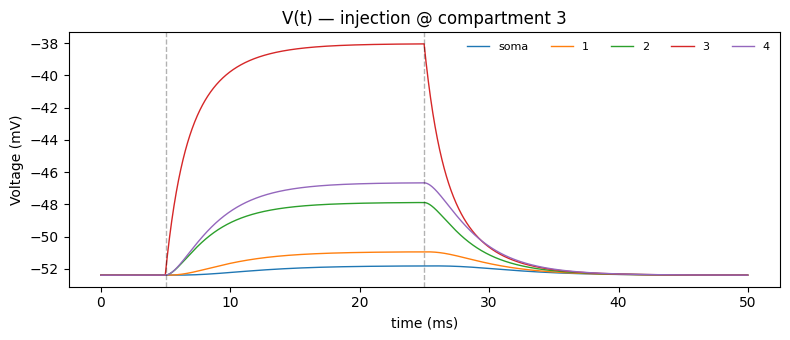

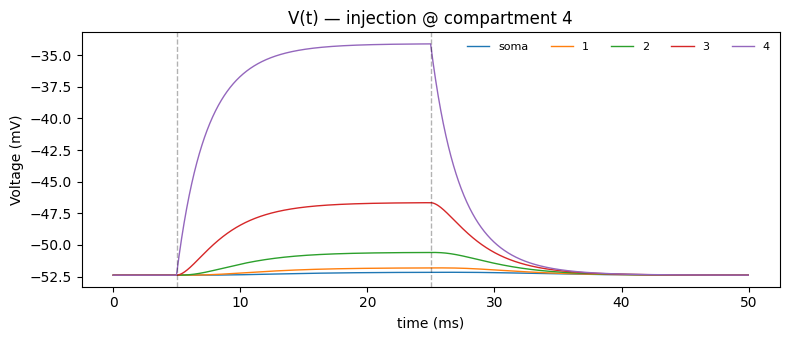

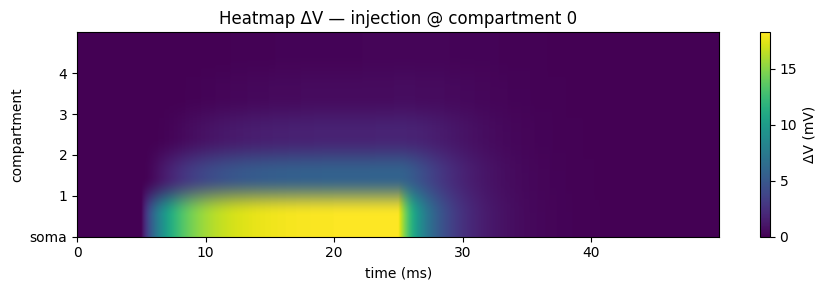

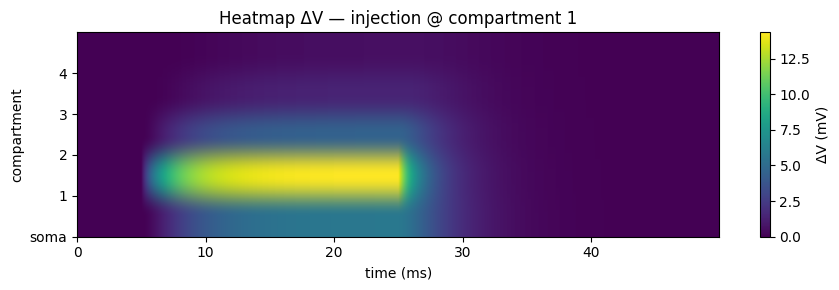

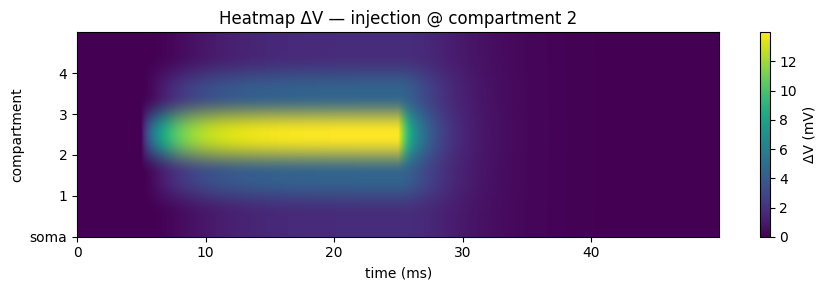

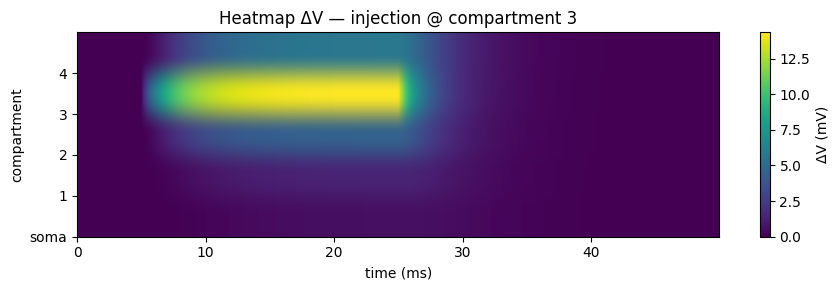

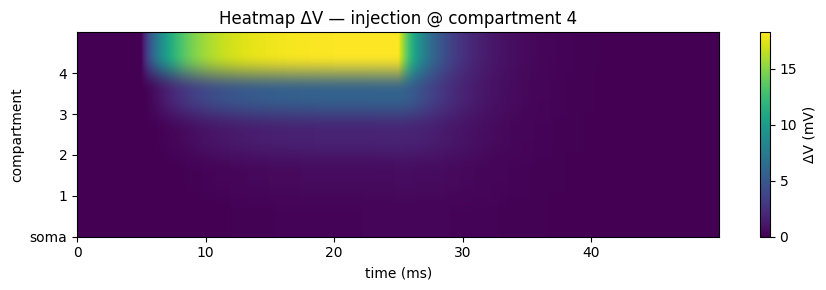

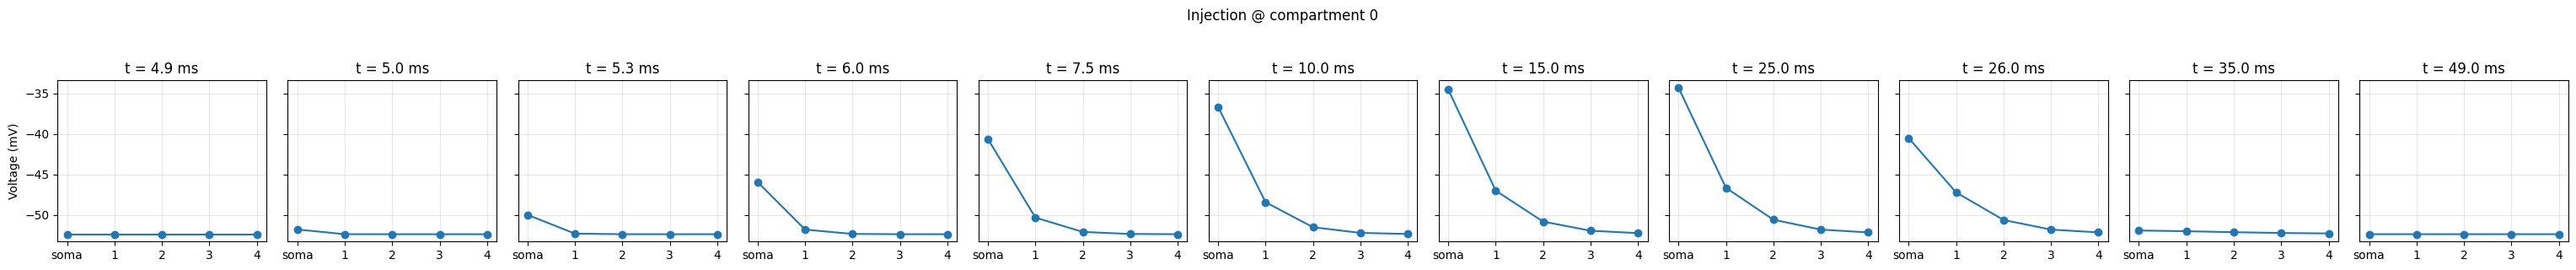

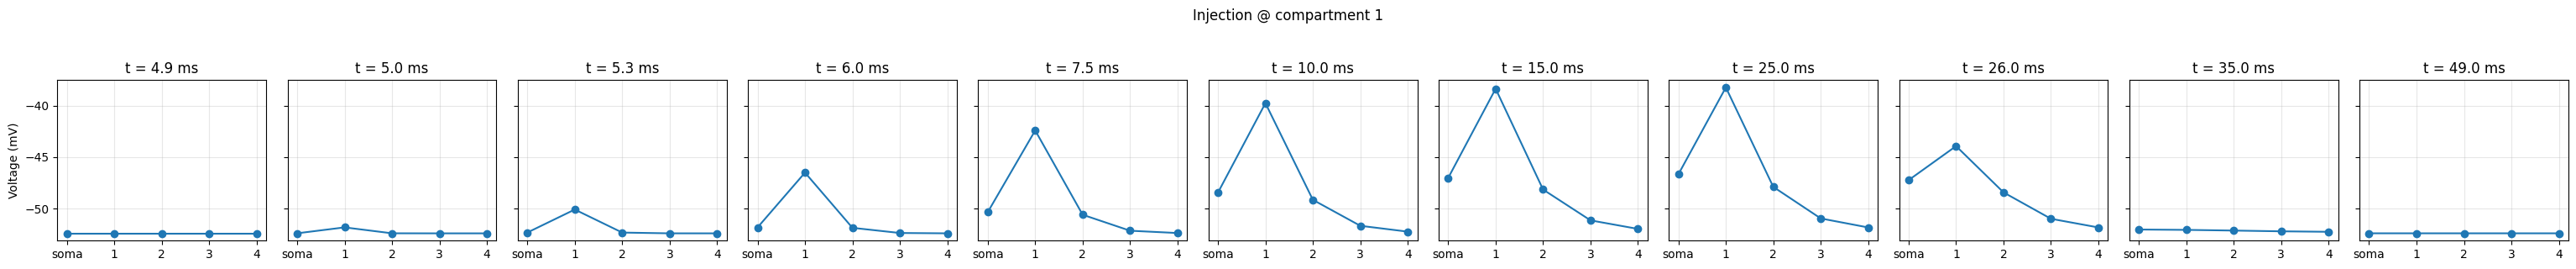

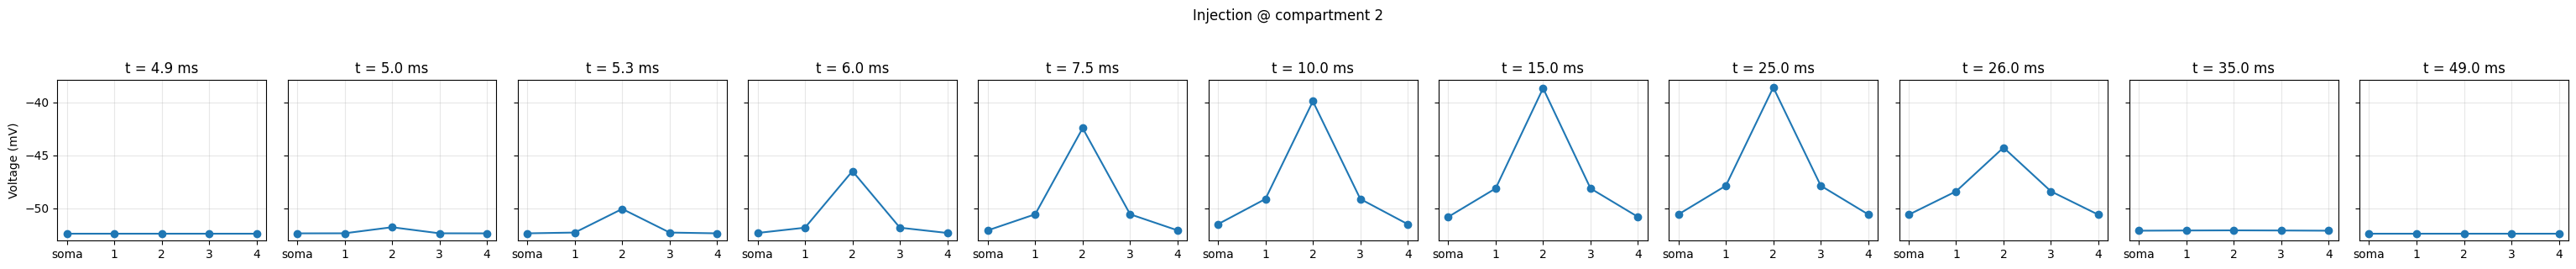

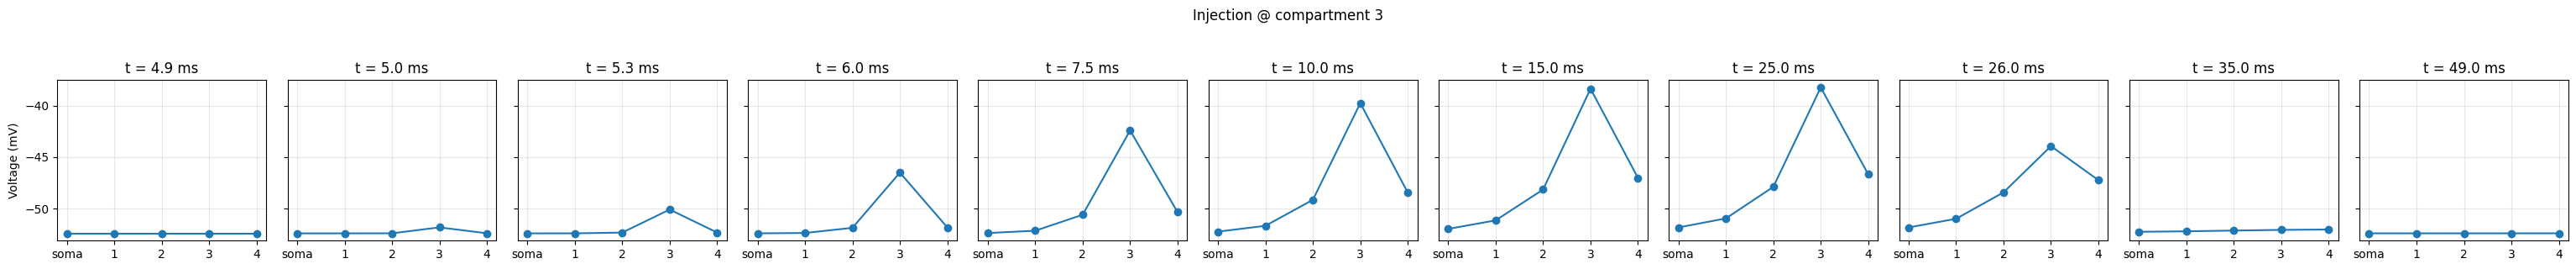

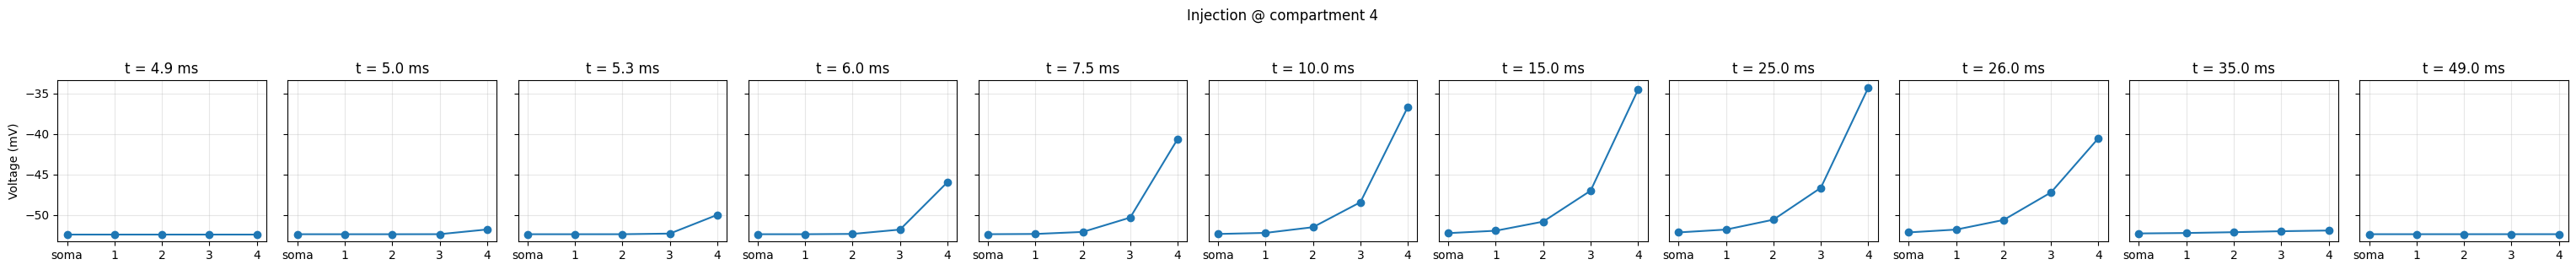

In [29]:
# === 4) Produce the figures you want (no analysis, just infrastructure) ===
comp_labels = ["soma", "1", "2", "3", "4"]

# (a) Time-trace overlays: one figure per injection
for i, V_i in enumerate(volts_by_inj):
    plot_traces_for_injection(
        V_i, dt, delay=delay, dur=dur,
        title=f"V(t) — injection @ compartment {i}",
        comp_labels=comp_labels
    )

# (b) Space–time heatmaps: one figure per injection
for i, V_i in enumerate(volts_by_inj):
    plot_spacetime_heatmap(
        V_i, dt, delay=delay,
        title=f"Heatmap ΔV — injection @ compartment {i}",
        comp_labels=comp_labels,
        baseline_subtract=True
    )

# (c) (optional) Snapshot panels across compartments at selected times
times = [4.9, 5.05, 5.30, 6.0, 7.5, 10.0, 15.0, 25.0, 26.0, 35.0, 49.0]
plot_all_injections(volts_by_inj, times, dt, comp_labels=comp_labels)


In [30]:
# === gradient factor extractors (no modeling, just sensitivities) ===


def extract_grad_factors_soma(model, phys_params, inj_currents, dt):
    """
    Returns:
      dVsoma_dgNa_by_inj : list of 5 arrays, each (T,)
      dVsoma_dgK_by_inj  : list of 5 arrays, each (T,)
    """
    dNa, dK = [], []
    with jax.disable_jit():
        for i, I_i in enumerate(inj_currents):
            dNa.append(np.asarray(dVsoma_dp(phys_params, "HH_gNa", i, I_i, model, dt)))
            dK .append(np.asarray(dVsoma_dp(phys_params, "HH_gK",  i, I_i, model, dt)))
    return dNa, dK

def extract_fullstate_sensitivity(model, phys_params, inj_currents, dt, key="HH_gNa"):
    """
    Full-state sensitivity for each injection i:
      Y_by_inj[i] = dV(t,c) / d(key[i])  with shape (T, N)
    """
    Ys = []
    with jax.disable_jit():
        for i, I_i in enumerate(inj_currents):
            Ys.append(np.asarray(full_state_sensitivity(phys_params, key, i, I_i, model, dt)))
    return Ys


In [ ]:
dNa_by, dK_by = extract_grad_factors_soma(model, phys_params_for_viz, inj_currents, dt)
# Optional full-state versions:
Yfull_Na_by = extract_fullstate_sensitivity(model, phys_params_for_viz, inj_currents, dt, key="HH_gNa")
Yfull_K_by  = extract_fullstate_sensitivity(model, phys_params_for_viz, inj_currents, dt, key="HH_gK")

print("[info] gradients:",
      f"dVsoma/dgNa shapes = {[y.shape for y in dNa_by]}",
      f"dVsoma/dgK  shapes = {[y.shape for y in dK_by]}")
# Yfull_*_by would each be 5 items of shape (T, N)


In [ ]:
def plot_gradfactor_traces(y_by_inj, dt, delay=None, dur=None, title_prefix="dA/dp"):
    for i, y in enumerate(y_by_inj):
        t = np.arange(len(y)) * dt
        plt.figure(figsize=(8, 3.0))
        plt.plot(t, y, lw=1.2)
        if delay is not None:
            plt.axvline(delay,      color='k', ls='--', lw=1, alpha=0.3)
            plt.axvline(delay+dur,  color='k', ls='--', lw=1, alpha=0.3)
        plt.xlabel("time (ms)"); plt.ylabel("sensitivity")
        plt.title(f"{title_prefix} — injection @ compartment {i}")
        plt.tight_layout(); plt.show()

def plot_grad_heatmap_fullstate(Y_i, dt, title="dV/dp (full-state)"):
    T, C = Y_i.shape
    t = np.arange(T) * dt
    plt.figure(figsize=(9, 3))
    plt.imshow(Y_i.T, aspect='auto', origin='lower', extent=(t[0], t[-1], 0, C))
    plt.colorbar(label="sensitivity")
    plt.yticks(range(C), ["soma","1","2","3","4"])
    plt.xlabel("time (ms)"); plt.ylabel("compartment"); plt.title(title)
    plt.tight_layout(); plt.show()

In [ ]:
# dA/dp time traces (soma readout)
plot_gradfactor_traces(dNa_by, dt, delay, dur, title_prefix="dVsoma/dgNa[i]")
plot_gradfactor_traces(dK_by,  dt, delay, dur, title_prefix="dVsoma/dgK[i]")

# full-state heatmaps 
for i, Y in enumerate(Yfull_Na_by): plot_grad_heatmap_fullstate(Y, dt, f"dV/dgNa[{i}]")
for i, Y in enumerate(Yfull_K_by):  plot_grad_heatmap_fullstate(Y, dt, f"dV/dgK[{i}]")


In [ ]:
# --- extract full-state sensitivities for both params (Na, K) ---
def extract_fullstate_all(model, phys_params, inj_currents, dt):
    Y_na, Y_k = [], []
    for i, I_i in enumerate(inj_currents):
        Y_na.append(np.asarray(full_state_sensitivity(phys_params, "HH_gNa", i, I_i, model, dt)))  # (T,C)
        Y_k .append(np.asarray(full_state_sensitivity(phys_params, "HH_gK",  i, I_i, model, dt)))  # (T,C)
    return Y_na, Y_k  # lists of length 5, each (T,C)

Yfull_Na_by, Yfull_K_by = extract_fullstate_all(model, phys_params_for_viz, inj_currents, dt)

# --- also keep the soma-only vectors for convenience (slice column 0) ---
dNa_by = [Y[:, 0] for Y in Yfull_Na_by]  # each (T,)
dK_by  = [Y[:, 0] for Y in Yfull_K_by]   # each (T,)

# --- quick sanity: matches your previous dVsoma_dp within tolerance ---
for i, I_i in enumerate(inj_currents):
    y_direct = np.asarray(dVsoma_dp(phys_params_for_viz, "HH_gNa", i, I_i, model, dt))
    err = float(np.max(np.abs(y_direct - dNa_by[i])))
    print(f"[check] inj {i} max|from_full - direct| (Na) = {err:.3e}")


In [ ]:
def plot_fullstate_sens_heatmap(Y_i, dt, title):
    T, C = Y_i.shape
    t = np.arange(T)*dt
    plt.figure(figsize=(9,3))
    plt.imshow(Y_i.T, aspect='auto', origin='lower', extent=(t[0], t[-1], 0, C))
    plt.colorbar(label="dV/dp")
    plt.yticks(range(C), ["soma","1","2","3","4"])
    plt.xlabel("time (ms)"); plt.ylabel("compartment"); plt.title(title)
    plt.tight_layout(); plt.show()

plot_fullstate_sens_heatmap(Yfull_Na_by[2], dt, "dV/dgNa[2]")
plot_fullstate_sens_heatmap(Yfull_K_by[2],  dt, "dV/dgK[2]")



Per-injection sensitivity summary (||·||2, max|·|, t_at_max):
inj 0: dV/dgK -> ||.||=7.401e-04, max=4.216e-05 @t=1016 | dV/dgNa -> ||.||=8.372e-07, max=4.106e-08 @t=1000
inj 1: dV/dgK -> ||.||=5.615e-05, max=2.951e-06 @t=1049 | dV/dgNa -> ||.||=5.427e-08, max=2.569e-09 @t=1007
inj 2: dV/dgK -> ||.||=1.539e-05, max=7.790e-07 @t=1093 | dV/dgNa -> ||.||=1.473e-08, max=6.859e-10 @t=1029
inj 3: dV/dgK -> ||.||=5.396e-06, max=2.659e-07 @t=1151 | dV/dgNa -> ||.||=5.239e-09, max=2.439e-10 @t=1069
inj 4: dV/dgK -> ||.||=8.358e-06, max=4.101e-07 @t=1227 | dV/dgNa -> ||.||=9.578e-09, max=4.500e-10 @t=1130


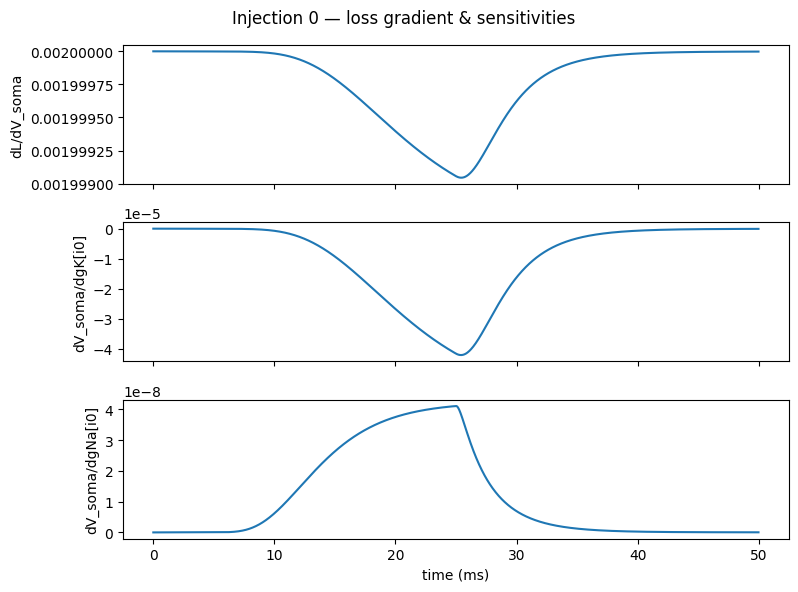

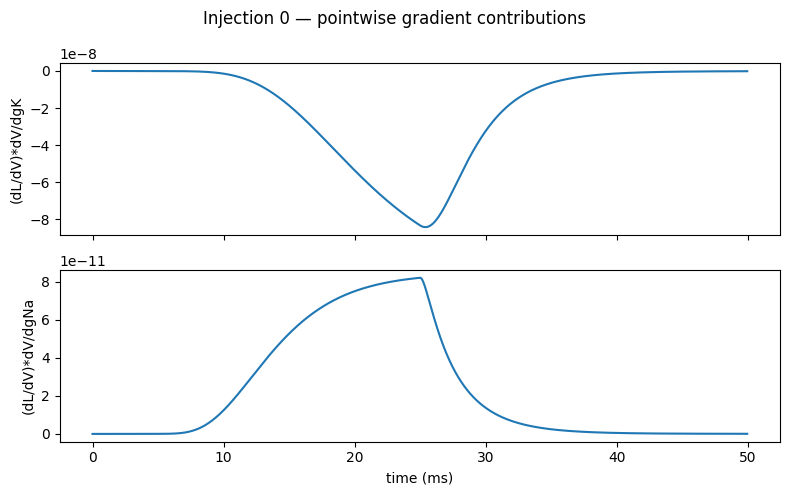

In [ ]:
def _row_stats(x):
    return float(jnp.linalg.norm(x)), float(jnp.max(jnp.abs(x))), int(jnp.argmax(jnp.abs(x)))

print("\nPer-injection sensitivity summary (||·||2, max|·|, t_at_max):")
for i in range(N):
    k_norm, k_max, k_t   = _row_stats(sensK_all[i])
    na_norm, na_max, na_t= _row_stats(sensNa_all[i])
    print(f"inj {i}: dV/dgK -> ||.||={k_norm:.3e}, max={k_max:.3e} @t={k_t:4d} | "
          f"dV/dgNa -> ||.||={na_norm:.3e}, max={na_max:.3e} @t={na_t:4d}")

t = jnp.arange(T) * dt
i0 = 0  # choose which injection to view
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
axs[0].plot(t, dLdV_all[i0]);      axs[0].set_ylabel("dL/dV_soma")
axs[1].plot(t, sensK_all[i0]);     axs[1].set_ylabel("dV_soma/dgK[i0]")
axs[2].plot(t, sensNa_all[i0]);    axs[2].set_ylabel("dV_soma/dgNa[i0]")
axs[2].set_xlabel("time (ms)")
fig.suptitle(f"Injection {i0} — loss gradient & sensitivities"); plt.tight_layout(); plt.show()

fig, axs = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
axs[0].plot(t, contribK_all[i0]);  axs[0].set_ylabel("(dL/dV)*dV/dgK")
axs[1].plot(t, contribNa_all[i0]); axs[1].set_ylabel("(dL/dV)*dV/dgNa"); axs[1].set_xlabel("time (ms)")
fig.suptitle(f"Injection {i0} — pointwise gradient contributions"); plt.tight_layout(); plt.show()

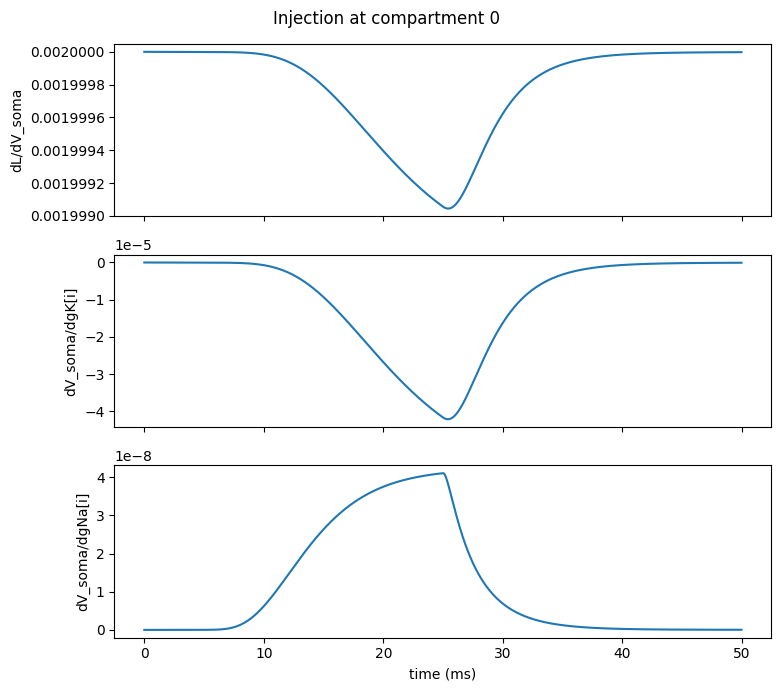

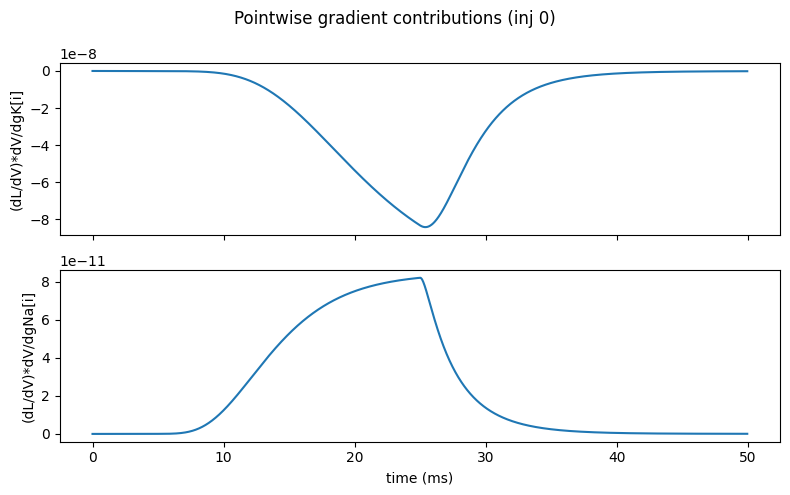

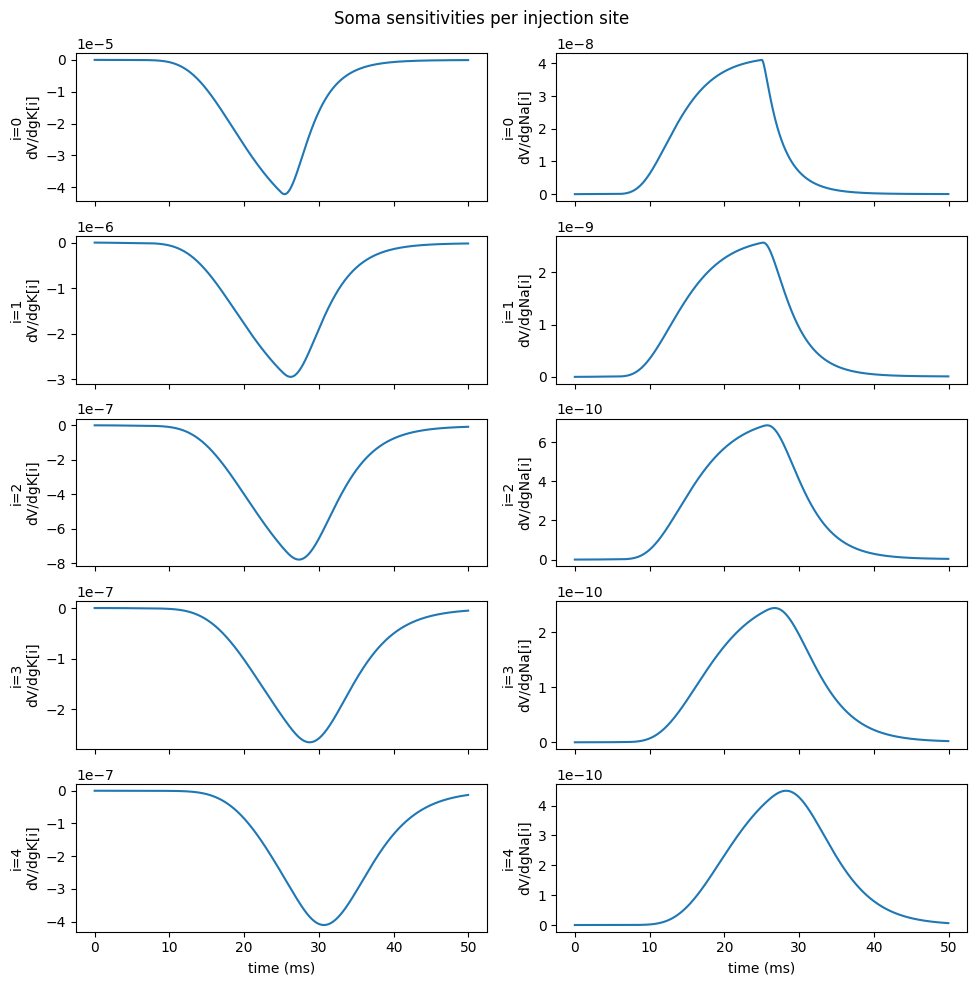

In [ ]:
def plot_time_series_for_injection(i):
    t = jnp.arange(T) * dt
    contrib_K  = dLdV_all[i] * sensK_all[i]
    contrib_Na = dLdV_all[i] * sensNa_all[i]

    fig, axs = plt.subplots(3, 1, figsize=(8, 7), sharex=True)
    axs[0].plot(t, dLdV_all[i]);      axs[0].set_ylabel("dL/dV_soma")
    axs[1].plot(t, sensK_all[i]);     axs[1].set_ylabel("dV_soma/dgK[i]")
    axs[2].plot(t, sensNa_all[i]);    axs[2].set_ylabel("dV_soma/dgNa[i]")
    axs[2].set_xlabel("time (ms)")
    fig.suptitle(f"Injection at compartment {i}")
    plt.tight_layout(); plt.show()

    fig, axs = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
    axs[0].plot(t, contrib_K);  axs[0].set_ylabel("(dL/dV)*dV/dgK[i]")
    axs[1].plot(t, contrib_Na); axs[1].set_ylabel("(dL/dV)*dV/dgNa[i]")
    axs[1].set_xlabel("time (ms)")
    fig.suptitle(f"Pointwise gradient contributions (inj {i})")
    plt.tight_layout(); plt.show()

def plot_grid_of_sensitivities():
    t = jnp.arange(T) * dt
    fig, axs = plt.subplots(N, 2, figsize=(10, 2.0*N), sharex=True)
    for i in range(N):
        axs[i,0].plot(t, sensK_all[i]);  axs[i,0].set_ylabel(f"i={i}\ndV/dgK[i]")
        axs[i,1].plot(t, sensNa_all[i]); axs[i,1].set_ylabel(f"i={i}\ndV/dgNa[i]")
    axs[-1,0].set_xlabel("time (ms)"); axs[-1,1].set_xlabel("time (ms)")
    fig.suptitle("Soma sensitivities per injection site")
    plt.tight_layout(); plt.show()

# example usage:
plot_time_series_for_injection(0)   # zoom into a single injection
plot_grid_of_sensitivities()        # overview across all 5 injections